In [ ]:
%pip uninstall fc -y


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# if working in the sandbox, fc is already installed.
#%pip install --extra-index-url=https://packages.dea.ga.gov.au/ fc

%pip install git+https://github.com/GeoscienceAustralia/fc.git -q


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import yaml
import json
import warnings
import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from fc.fractional_cover import (
    fractional_cover,
)  # import the FC package after installing it above

from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
from odc.algo import keep_good_only
from odc.algo._percentile import xr_quantile_bands
from odc.algo._masking import _fuse_mean_np, _fuse_or_np, _xr_fuse, mask_cleanup
from datacube.model import Measurement
from datacube.utils import unsqueeze_dataset

import sys

sys.path.insert(1, "/home/jovyan/dev/Tools/")
from dea_tools.datahandling import load_ard
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import rgb

warnings.filterwarnings("ignore")


In [ ]:
client = create_local_dask_cluster(return_client=True)


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/42301/status,
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/42301/status,Workers: 1
Total threads: 7,Total memory: 58.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39921,Workers: 1
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/42301/status,Total threads: 7
Started: Just now,Total memory: 58.90 GiB
Comm: tcp://127.0.0.1:43289,Total threads: 7
Dashboard: /user/jenna.guffogg@ga.gov.au/proxy/37785/status,Memory: 58.90 GiB
Nanny: tcp://127.0.0.1:43239,


In [ ]:
def run_fc_multi(nbart: xr.Dataset, measurements, regression_coefficients):
    results = []
    times = nbart.time.values
    for t in times:
        # Select one time slice and remove the time dimension
        input_tile = nbart.sel(time=t)
        if "time" in input_tile.dims:
            input_tile = input_tile.squeeze("time").drop("time")
        data = fractional_cover(input_tile, measurements, regression_coefficients)
        # Add time back in
        output_tile = unsqueeze_dataset(data, "time", t)
        results.append(output_tile)
    # Concatenate along time
    combined = xr.concat(results, dim="time")
    return combined


In [ ]:
MEASUREMENTS = [
    {
        "name": "BS",
        "src_var": "BS",
        "units": "percent",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Bare ground fraction percentage",
            "comment": "Fraction of bare ground including rock, bare and disturbed soil, within the Landsat pixel as percentages",
            "alias": "bare",
            "coverage_content_type": "modelResult",
        },
        "aliases": ["bare"],
    },
    {
        "name": "PV",
        "src_var": "PV",
        "units": "percent",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Green cover fraction percentage",
            "comment": "Fraction of green cover including green groundcover and green leaf material over all strata, within the Landsat pixel, as percentages",
            "alias": "green",
            "coverage_content_type": "modelResult",
        },
        "aliases": ["green_veg"],
    },
    {
        "name": "NPV",
        "src_var": "NPV",
        "units": "percent",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Non-green cover fraction percentage",
            "comment": "Fraction of non green cover including litter, dead leaf and branches over all strata, within the Landsat pixel, as percentages",
            "alias": "dead",
            "coverage_content_type": "modelResult",
        },
        "aliases": ["dead_veg"],
    },
    {
        "name": "UE",
        "src_var": "UE",
        "units": "1",
        "dtype": "int8",
        "nodata": -1,
        "zlib": True,
        "fletcher32": True,
        "attrs": {
            "long_name": "Unmixing error",
            "comment": "Euclidean Norm of the Residual Vector",
            "alias": "err",
            "coverage_content_type": "qualityInformation",
        },
        "aliases": ["err"],
    },
]


In [ ]:
"""
You need to convert your MEASUREMENTS list of dicts into a list of objects that have a .name attribute.
If you want a quick fix, you can use a namedtuple:
"""

MEASUREMENTS_OBJ = [Measurement(**m) for m in MEASUREMENTS]


In [ ]:
LANDSAT_SENSOR_REGRESSION_COEFFICIENTS = {
    "blue": [0.00041, 0.97470],
    "green": [0.00289, 0.99779],
    "red": [0.00274, 1.00446],
    "nir": [0.00004, 0.98906],
    "swir1": [0.00256, 0.99467],
    "swir2": [-0.00327, 1.02551],
}

SENTINEL_SENSOR_REGRESSION_COEFFICIENTS = {
    "blue": [-22.0, 0.9551],
    "green": [31.0, 1.0582],
    "red": [64.0, 0.9871],
    "nir": [120.0, 1.0187],
    "swir1": [79.0, 0.9528],
    "swir2": [-42.0, 0.9688],
}


In [ ]:
LANDSAT_BAND_MAPPING = (
    {"load_bands": ("green", "red", "nir", "swir1", "swir2"), "rename": None},
    {
        "load_bands": (
            "nbart_green",
            "nbart_red",
            "nbart_nir",
            "nbart_swir_1",
            "nbart_swir_2",
        ),
        "rename": {
            "nbart_green": "green",
            "nbart_red": "red",
            "nbart_nir": "nir",
            "nbart_swir_1": "swir1",
            "nbart_swir_2": "swir2",
        },
    },
)


In [ ]:
SENTINEL_BAND_MAPPING = (
    {"load_bands": ("green", "red", "nir", "swir1", "swir2"), "rename": None},
    {
        "load_bands": (
            "nbart_green",
            "nbart_red",
            "nbart_nir_1",
            "nbart_swir_2",
            "nbart_swir_3",
        ),
        "rename": {
            "nbart_green": "green",
            "nbart_red": "red",
            "nbart_nir_1": "nir",
            "nbart_swir_2": "swir1",
            "nbart_swir_3": "swir2",
        },
    },
)


In [ ]:
# region_code = ['x176y085'] #marysville
# region_code = ['x168y092'] #hopetoun
# region_code = ['x140y138'] #west macdonnell
# region_codes = ['x148y166'] #limmen NT - cloud heavy area
# region_codes = ['x175y066'] # Tas SW nat park


region_codes = ["x140y138"]

time = ("2022-01-01", "2022-02-01")

ls_measurements = [
    "nbart_green",
    "nbart_red",
    "nbart_blue",
    "nbart_nir",
    "nbart_swir_1",
    "nbart_swir_2",
]

s2_measurements = [
    "nbart_green",
    "nbart_red",
    "nbart_blue",
    "nbart_nir_1",
    "nbart_swir_2",  # closest match to landsat swir1
    "nbart_swir_3",  # closest match to landsat swir2
]
# dask_chunks = dict(x=1024, y=1024, time=1)


In [ ]:
# open tiles and select

gdf = gpd.read_file(
    "~/gdata1/projects/fc-sub-annual/data/testing_minitile_suite.geojson"
)

gdf = gdf[gdf["region_code"].isin(region_codes)]

geom = Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)


In [ ]:
dc = datacube.Datacube(app="fc_ls_test")

query = {
    "time": time,
    "geopolygon": geom,
    "dask_chunks": {},
    "group_by": "solar_day",
    "output_crs": "EPSG:3577",
}


In [ ]:
# gdf.explore(
#     tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#     attr='Esri',
#     name='Esri satellite'
# )


In [ ]:
ls_ds = load_ard(
    dc=dc,
    products=["ga_ls8c_ard_3", "ga_ls9c_ard_3"],
    measurements=ls_measurements,
    resolution=(-60, 60),
    cloud_mask="fmask",
    mask_pixel_quality=True,
    fmask_categories=["valid", "snow", "water"],
    mask_filters=[("dilation", 5)],
    mask_contiguity=True,
    skip_broken_datasets=True,
    verbose=True,
    **query,
)


Finding datasets
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Applying morphological filters to pixel quality mask: [('dilation', 5)]
Applying fmask pixel quality/cloud mask
Applying contiguity mask (oa_nbart_contiguity)
Returning 4 time steps as a dask array


In [ ]:
s2_ds = load_ard(
    dc=dc,
    products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    measurements=s2_measurements,
    resolution=(-60, 60),
    cloud_mask="s2cloudless",
    mask_pixel_quality=True,
    mask_contiguity=True,
    skip_broken_datasets=True,
    verbose=True,
    **query,
)


Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying s2cloudless pixel quality/cloud mask
Applying contiguity mask (oa_nbart_contiguity)
Returning 6 time steps as a dask array


In [ ]:
ls_ds


<xarray.Dataset> Size: 27MB
Dimensions:       (time: 4, y: 534, x: 534)
Coordinates:
  * time          (time) datetime64[ns] 32B 2022-01-01T01:07:41.691121 ... 20...
  * y             (y) float64 4kB -2.464e+06 -2.464e+06 ... -2.496e+06
  * x             (x) float64 4kB 6.399e+04 6.405e+04 ... 9.591e+04 9.597e+04
    spatial_ref   int32 4B 3577
Data variables:
    nbart_green   (time, y, x) float32 5MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_red     (time, y, x) float32 5MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_blue    (time, y, x) float32 5MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_nir     (time, y, x) float32 5MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 5MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 5MB dask.array<chunksize=(1, 534, 534), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
# rgb(ls_ds, bands=["nbart_blue", "nbart_green", "nbart_red"], col="time", size=4)


In [ ]:
# rgb(
#     s2_ds,
#     bands=["nbart_blue", "nbart_green", "nbart_red"],
#     col="time",
#     col_wrap=4,
#     size=4,
# )


In [ ]:
for mapping in LANDSAT_BAND_MAPPING:
    if mapping["rename"]:
        ls_rename_dict = mapping["rename"]
        break

for mapping in SENTINEL_BAND_MAPPING:
    if mapping["rename"]:
        s2_rename_dict = mapping["rename"]
        break

ls_renamed = ls_ds.rename(ls_rename_dict)

s2_renamed = s2_ds.rename(s2_rename_dict)


In [ ]:
ls_fc = run_fc_multi(
    ls_renamed, MEASUREMENTS_OBJ, LANDSAT_SENSOR_REGRESSION_COEFFICIENTS
)


/env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


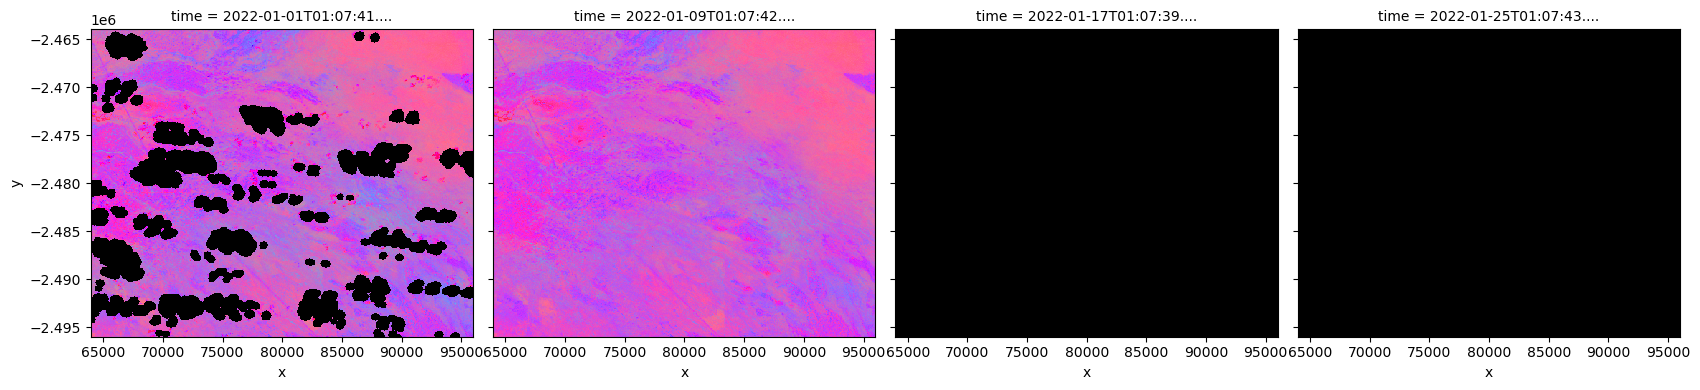

In [ ]:
rgb(ls_fc, bands=["BS", "PV", "NPV"], col="time", size=4, col_wrap=4)


In [ ]:
s2_fc = run_fc_multi(
    s2_renamed, MEASUREMENTS_OBJ, SENTINEL_SENSOR_REGRESSION_COEFFICIENTS
)


In [ ]:
rgb(s2_fc, bands=["BS", "PV", "NPV"], col="time", col_wrap=4, size=4)


In [ ]:
for coord in ls_ds.coords:
    if coord not in ls_fc.coords:
        ls_fc = ls_fc.assign_coords({coord: ls_ds.coords[coord]})
ls_fc.attrs = ls_ds.attrs.copy()

merged_ls = xr.merge([ls_ds, ls_fc])


In [ ]:
for coord in s2_ds.coords:
    if coord not in s2_fc.coords:
        s2_fc = s2_fc.assign_coords({coord: s2_ds.coords[coord]})
s2_fc.attrs = s2_ds.attrs.copy()

merged_s2 = xr.merge([s2_ds, s2_fc])


In [ ]:
time_idx = 0

# Select DataArrays for plotting
true_colour = xr.concat(
    [
        merged_ls["nbart_red"].isel(time=time_idx),
        merged_ls["nbart_green"].isel(time=time_idx),
        merged_ls["nbart_blue"].isel(time=time_idx),
    ],
    dim="band",
)
true_colour = true_colour.transpose("y", "x", "band")  # shape: (y, x, band)

fc_colour = xr.concat(
    [
        merged_ls["BS"].isel(time=time_idx),
        merged_ls["PV"].isel(time=time_idx),
        merged_ls["NPV"].isel(time=time_idx),
    ],
    dim="band",
)
fc_colour = fc_colour.transpose("y", "x", "band")  # shape: (y, x, band)

crs = ccrs.epsg(3577)  # Use your dataset's CRS

fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": crs})

# True colour plot
axes[0].imshow(
    true_colour.values / 3000,
    extent=[merged_ls.x.min(), merged_ls.x.max(), merged_ls.y.min(), merged_ls.y.max()],
    origin="upper",
)
axes[0].set_title("True Colour")
axes[0].set_extent(
    [merged_ls.x.min(), merged_ls.x.max(), merged_ls.y.min(), merged_ls.y.max()], crs
)
axes[0].coastlines()

# FC composite plot
axes[1].imshow(
    fc_colour.values / 100,
    extent=[merged_ls.x.min(), merged_ls.x.max(), merged_ls.y.min(), merged_ls.y.max()],
    origin="upper",
)
axes[1].set_title("Fractional Cover Composite")
axes[1].set_extent(
    [merged_ls.x.min(), merged_ls.x.max(), merged_ls.y.min(), merged_ls.y.max()], crs
)
axes[1].coastlines()

plt.tight_layout()
plt.show()


In [ ]:
time_idx = 0

# Select DataArrays for plotting
true_colour = xr.concat(
    [
        merged_s2["nbart_red"].isel(time=time_idx),
        merged_s2["nbart_green"].isel(time=time_idx),
        merged_s2["nbart_blue"].isel(time=time_idx),
    ],
    dim="band",
)
true_colour = true_colour.transpose("y", "x", "band")  # shape: (y, x, band)

fc_colour = xr.concat(
    [
        merged_s2["BS"].isel(time=time_idx),
        merged_s2["PV"].isel(time=time_idx),
        merged_s2["NPV"].isel(time=time_idx),
    ],
    dim="band",
)
fc_colour = fc_colour.transpose("y", "x", "band")  # shape: (y, x, band)

crs = ccrs.epsg(3577)  # Use your dataset's CRS

fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": crs})

# True colour plot
axes[0].imshow(
    true_colour.values / 3000,
    extent=[merged_s2.x.min(), merged_s2.x.max(), merged_s2.y.min(), merged_s2.y.max()],
    origin="upper",
)
axes[0].set_title("True Colour")
axes[0].set_extent(
    [merged_s2.x.min(), merged_s2.x.max(), merged_s2.y.min(), merged_s2.y.max()], crs
)
axes[0].coastlines()

# FC composite plot
axes[1].imshow(
    fc_colour.values / 100,
    extent=[merged_s2.x.min(), merged_s2.x.max(), merged_s2.y.min(), merged_s2.y.max()],
    origin="upper",
)
axes[1].set_title("Fractional Cover Composite")
axes[1].set_extent(
    [merged_s2.x.min(), merged_s2.x.max(), merged_s2.y.min(), merged_s2.y.max()], crs
)
axes[1].coastlines()

plt.tight_layout()
plt.show()


## merge sensors

In [ ]:
# both Landsat and Sentinel-2 FC datasets merged here.
# NOTE: This is probably not done correctly and is for demo purposes/ Jenna learning only

merged_ls_dim = merged_ls.expand_dims(sensor=["landsat"])
merged_s2_dim = merged_s2.expand_dims(sensor=["sentinel-2"])


In [ ]:
merged_all = xr.concat([merged_ls_dim, merged_s2_dim], dim="sensor")


## calculating percentiles

In [ ]:
stacked_fc = merged_all.stack(observation=("sensor", "time"))


In [ ]:
stacked_pc = xr_quantile_bands(stacked_fc, quantiles=[0.1, 0.5, 0.9], nodata=255)
ls_pc = xr_quantile_bands(ls_fc, quantiles=[0.1, 0.5, 0.9], nodata=255)
s2_pc = xr_quantile_bands(s2_fc, quantiles=[0.1, 0.5, 0.9], nodata=255)


In [ ]:
rgb(stacked_pc, bands=["BS_pc_90", "PV_pc_90", "NPV_pc_90"])


In [ ]:
rgb(ls_pc, bands=["BS_pc_90", "PV_pc_90", "NPV_pc_90"])


In [ ]:
rgb(s2_pc, bands=["BS_pc_90", "PV_pc_90", "NPV_pc_90"])
